# Configuration and parameterization tutorial

This notebook outlines the steps required to generate the files used to configure the [vadose](../docs/_build/html/vadoseZone.html), [groundwater](../docs/_build/html/groundwaterZone.html), and [channel](../docs/_build/html/channel.html) zones associated with each [REW](../docs/_build/html/REW.html).

In [1]:
%matplotlib inline
import os
import sys
from os.path import dirname
import pickle
import gdal
import fiona
import glob
import shapely
from shapely import geometry,ops
import numpy as np
import fiona
import shapely
from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap
import matplotlib.cm as cm
import geopandas as gp
import seaborn
import pyproj
parent_dir = dirname(dirname(os.getcwd()))
sys.path.append(os.path.join(parent_dir,'StreamflowTempModel','1_data_preparation'))

This tutorial assumes that an REW network has previously been extracted using the network extraction GRASS tool provided in the data preparation folder. Instructions for running this tool can be found in the [GRASS GIS tutorial](). 

Three python files are used for model configuration and parameterization, all of which can be found in the `1_data_preparation` directory of the model folder. 

##  1. Prepare model configuration - `prep_model_config.py`

This configuration script can be edited to change the particulars of models' numerical solvers, as well as the start and stop dates for running the model. Simply run the script to write the configuration data to a file. 

In [2]:
from prep_model_config import main as prep_model_config
prep_model_config()
model_config = pickle.load(open( os.path.join(parent_dir,'model_data','model_config.p'), "rb" ) )
print model_config.keys()

['resample_freq_hillslope', 'dt_hillslope', 'spinup_date', 'Tmax', 'resample_freq_channel', 't_hillslope', 'stop_date', 'timestamps_channel', 'dt_channel', 't_channel', 'timestamps_hillslope', 'start_date']


Keys of the model configuration dictionary include:
* `start_date` (datetime instance): Start date for running model
* `stop_date` (datetime instance): Stop date for running model
* `spinup_date` (datetime instance): Date after which model has spun up. Only calibrate model after this date.
* `Tmax` (float): Number of days of simulation
* `dt_hillslope` (float): Hillslope simulation timestep in days
* `dt_channel` (float): Channel simulation timestep in days
* `resample_freq_hillslope` (float): Frequency at which to resample forcing data depending on timestep to solve the hillslope model
* `resample_freq_channel` (float): Frequency at which to resample forcing data depending on timestep to solve the channel model
* `timestamps_hillslope` (datetimes): Times at which to simulate hillslope dynamics
* `timestamps_channel` (datetimes): Times at which to simulate channel dynamics

To change any of these model configuration variables, use your favorite text editor to alter their values in the `prep_model_config.py` file, then re-run the script. 

There are some restrictions on allowable values of these configuration variables. All model time units are expressed in days, and the minimum model timestep is one minute, therefore, `dt_hillslope` and `dt_channel` must be greater than or equal to $\frac{1}{1440}$ days. The `spinup_date` is a user specified date after which initial model solution transients can be considered negligible. This date is important for calibration, as the model is only calibrated using model generated data after `spinup_date`. The model itself, however, is run from `start_date` to `stop_date`. Current model spin up time is one year: 

In [3]:
print("Model run start date is: %s \nModel is spun up after: %s \nModel run end date is: %s" % (str(model_config['start_date']), str(model_config['spinup_date']), str(model_config['stop_date'])))

Model run start date is: 2012-07-01 
Model is spun up after: 2013-07-01 
Model run end date is: 2014-12-30


## 2. Configure REWs - `prep_rew_config.py`

This python script converts GIS data related to stream network topology and physical characteristics (see [GRASS GIS tutorial]()) into a Pandas dataframe that is written to `rew_config.p` in the `model_data directory`. 



Fetching REW configuration data...
REW IDs used: [2, 4, 6, 8, 10]
Corresponding basin IDs: [2, 4, 6, 8, 10]
REW IDs and basin IDs match!
Total number of REW IDs used: 5
Total number of unique REW group(s): 1

Watershed with REW sub-basins. 
All stream network information is stored in rew_config 
e.g. Streams 10 and 4 feed into stream 2


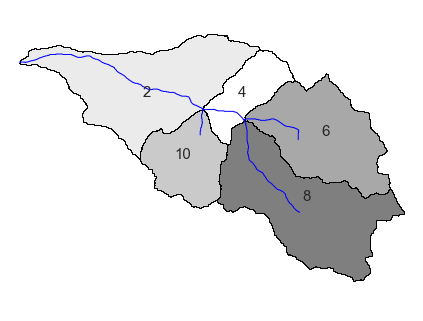

In [6]:
from prep_rew_config import main as prep_rew_config
prep_rew_config()
rew_config = pickle.load( open( os.path.join(parent_dir,'model_data','rew_config.p'), "rb" ) )

basins = glob.glob(os.path.join(parent_dir,'raw_data','basins_poly','*.shp'))[0]
basins_shape = gp.GeoDataFrame.from_file(basins)
basins_shape['coords'] = basins_shape['geometry'].apply(lambda x: x.representative_point().coords[:])
basins_shape['coords'] = [coords[0] for coords in basins_shape['coords']]

ax1 = basins_shape.plot()
for idx, row in basins_shape.iterrows():
    plt.annotate(s=row['cat'], xy=row['coords'],
                 horizontalalignment='center',fontsize=15)

streams = glob.glob(os.path.join(parent_dir,'raw_data','streams_poly','*.shp'))[0]
streams_shape = gp.GeoDataFrame.from_file(streams)
streams_shape.plot(ax=ax1,color='blue')

ax1.get_xaxis().set_ticks([])
ax1.get_yaxis().set_ticks([])
ax1.patch.set_facecolor('white')
prev_str01 = str(rew_config.prev_str01.loc[2])
prev_str02 = str(rew_config.prev_str02.loc[2])
title_str = 'Watershed with REW sub-basins. \nAll stream network information is stored in rew_config \n'
title_str += ("e.g. Streams %s and %s feed into stream %s" % (prev_str01,prev_str02,'2'))
print title_str

## 3. prep_rew_params.py